In [ ]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
dataset_root = '/content'

train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')


In [ ]:

# Original KDD dataset feature names obtained from 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']


In [ ]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

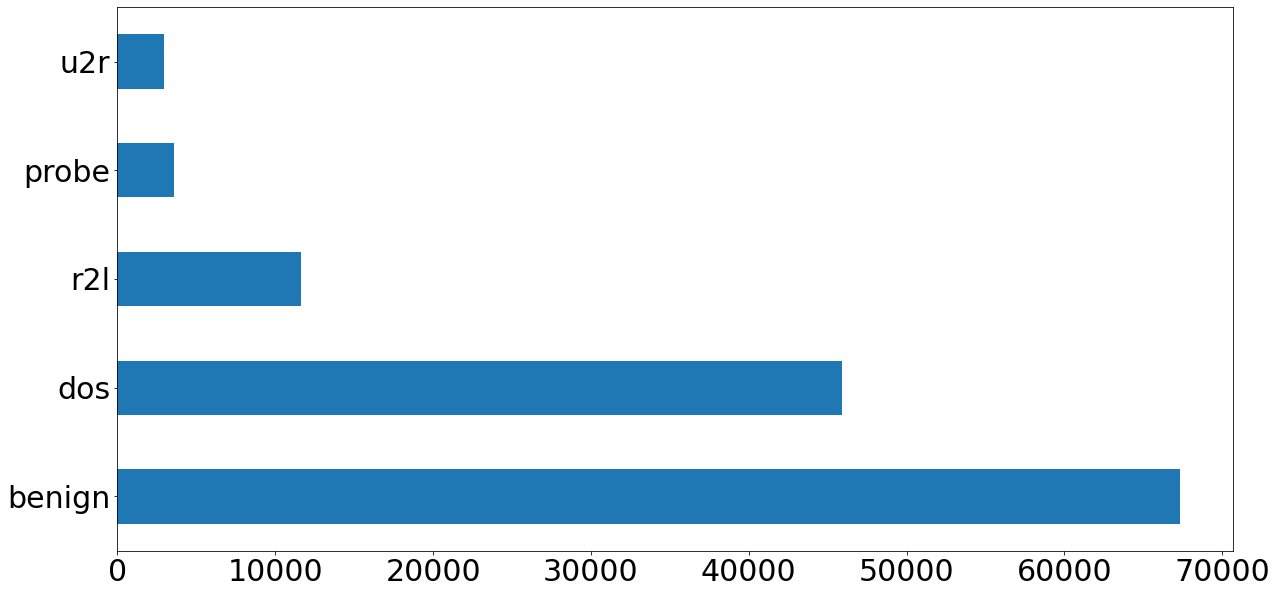

In [ ]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types



category = defaultdict(list)
category['benign'].append('normal')

with open('training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])


train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)


train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)


test_attack_types.plot(kind='barh', figsize=(20,10), fontsize=15)

test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)


In [ ]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0
#execute the commands in console

train_df[binary_cols].describe().transpose()


# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()


su_attempted
0    125952
1        21
dtype: int64

In [ ]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()

# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')


In [ ]:
"""
Data Preparation

"""
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)




combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]


In [ ]:
# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

#execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    
train_x.describe()


train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)


In [ ]:
"""
multi class classification using decision tree 

"""

# 5-class classification version
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss,classification_report,accuracy_score,f1_score

d_classifier = DecisionTreeClassifier(criterion='entropy',splitter ="random", max_depth=29,random_state=10)
d_classifier.fit(train_x, train_Y)

pred_y = d_classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
acc_d = accuracy_score(test_Y, pred_y)
con_d = classification_report(test_Y,pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)
print(acc_d)
print(con_d)

[[9432   77  197    2    3]
 [1411 6178   44    3    0]
 [ 327  163 1928    4    1]
 [1901  327  100  243    3]
 [ 154    0   25    2   19]]
0.2104329311568488
0.7895670688431512
              precision    recall  f1-score   support

      benign       0.71      0.97      0.82      9711
         dos       0.92      0.81      0.86      7636
       probe       0.84      0.80      0.82      2423
         r2l       0.96      0.09      0.17      2574
         u2r       0.73      0.10      0.17       200

    accuracy                           0.79     22544
   macro avg       0.83      0.55      0.57     22544
weighted avg       0.82      0.79      0.75     22544



**Assignment** **Part**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#1. Identify the attribute names (Header)
print (train_df.columns.values)

['duration' 'protocol_type' 'service' 'flag' 'src_bytes' 'dst_bytes'
 'land' 'wrong_fragment' 'urgent' 'hot' 'num_failed_logins' 'logged_in'
 'num_compromised' 'root_shell' 'su_attempted' 'num_root'
 'num_file_creations' 'num_shells' 'num_access_files' 'is_host_login'
 'is_guest_login' 'count' 'srv_count' 'serror_rate' 'srv_serror_rate'
 'rerror_rate' 'srv_rerror_rate' 'same_srv_rate' 'diff_srv_rate'
 'srv_diff_host_rate' 'dst_host_count' 'dst_host_srv_count'
 'dst_host_same_srv_rate' 'dst_host_diff_srv_rate'
 'dst_host_same_src_port_rate' 'dst_host_srv_diff_host_rate'
 'dst_host_serror_rate' 'dst_host_srv_serror_rate' 'dst_host_rerror_rate'
 'dst_host_srv_rerror_rate' 'attack_type' 'attack_category']


In [ ]:
#2. Check the length of the Train and Test dataset
print (train_df.shape)
print (test_df.shape)

(125973, 42)
(22544, 42)


In [ ]:
#3. Check the total number of samples that belong to each of the five classes of the trainingdataset.
print (train_df['attack_category'].value_counts())
print (test_df['attack_category'].value_counts())


benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_category, dtype: int64
benign    9711
dos       7636
r2l       2574
probe     2423
u2r        200
Name: attack_category, dtype: int64


**KNN**

In [ ]:
#1.  Implement at least 5 benchmark classificationalgorithms. 
#2. Tune the parameters if applicable to obtain a good solution.
#3. Obtain the confusion matrix for each of the scenarios.
#4. Calculate the performance measures of the each of the classification algorithms that includes
# Accuracy (%), Precision (%), Recall (%), F-Score (%), False Alarm- FPR (%)

#1
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(train_x,train_Y)
pred_k = knn.predict(test_x)
acc_k = knn.score(test_x, test_Y)
print (acc_k)
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
print(classification_report(test_Y,pred_k))
print(accuracy_score(test_Y,pred_k))
knn_con = confusion_matrix(test_Y,pred_k)


0.7551898509581263
              precision    recall  f1-score   support

      benign       0.66      0.97      0.78      9711
         dos       0.96      0.78      0.86      7636
       probe       0.82      0.62      0.71      2423
         r2l       0.93      0.06      0.10      2574
         u2r       0.82      0.04      0.09       200

    accuracy                           0.76     22544
   macro avg       0.84      0.49      0.51     22544
weighted avg       0.81      0.76      0.72     22544

0.7551898509581263
0.7551898509581263
0.7551898509581263
0.7551898509581263


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,pred_k, labels=["benign", "dos","probe","r2l","u2r"])
for i in range(len(mul_c)):
    confusion = mul_c[i]
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    print((TP + TN) / float(TP + TN + FP + FN)*100)

76.90738112136268
91.35024840312278
94.47303051809794
89.16341376863024
99.14389638041165


**Confusion matrix KNN**

Text(0.5, 15.0, 'Predicted label')

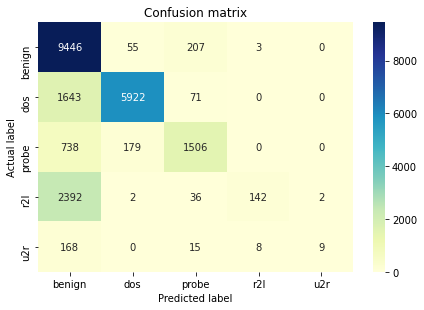

In [ ]:
# create heatmap
sns.heatmap(pd.DataFrame(knn_con), annot=True, cmap="YlGnBu" ,fmt='g',xticklabels= ['benign','dos','probe','r2l','u2r'],yticklabels=['benign','dos','probe','r2l','u2r'])
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Logistic Regression**

In [ ]:
#2
from sklearn.linear_model import LogisticRegression

lclf = LogisticRegression(random_state=42).fit(train_x,train_Y)
l_score = lclf.predict(test_x)
l_clf = lclf.score(test_x,test_Y)
print (l_clf)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_Y,l_score,digits=3))
ln_con = confusion_matrix(test_Y,l_score)

0.7530606813342796
              precision    recall  f1-score   support

      benign       0.66      0.93      0.77      9711
         dos       0.97      0.79      0.87      7636
       probe       0.74      0.75      0.75      2423
         r2l       0.91      0.04      0.07      2574
         u2r       0.80      0.04      0.08       200

    accuracy                           0.75     22544
   macro avg       0.81      0.51      0.51     22544
weighted avg       0.80      0.75      0.72     22544

0.7530606813342796
0.7530606813342796
0.7530606813342796


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,l_score, labels=["benign", "dos","probe","r2l","u2r"])

array([[[ 8122,  4711],
        [  718,  8993]],

       [[14714,   194],
        [ 1584,  6052]],

       [[19471,   650],
        [  598,  1825]],

       [[19960,    10],
        [ 2475,    99]],

       [[22342,     2],
        [  192,     8]]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,l_score, labels=["benign", "dos","probe","r2l","u2r"])
for i in range(len(mul_c)):
    confusion = mul_c[i]
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    print((TP + TN) / float(TP + TN + FP + FN)*100)

75.91820440028388
92.11320085166786
94.46415897799858
88.97711142654364
99.13946061036197


**Confusion Matrix LR**

Text(0.5, 15.0, 'Predicted label')

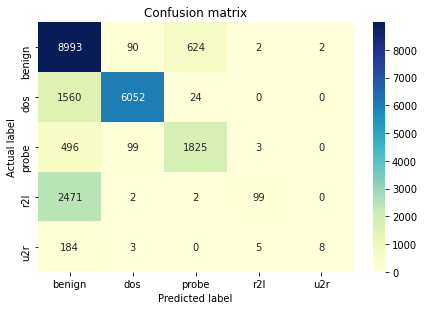

In [ ]:
# create heatmap
sns.heatmap(pd.DataFrame(ln_con), annot=True, cmap="YlGnBu" ,fmt='g',xticklabels= ['benign','dos','probe','r2l','u2r'],yticklabels=['benign','dos','probe','r2l','u2r'])
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Support Vector Machine**

In [ ]:
#3
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(train_x, train_Y)
svm_pred = svclassifier.predict(test_x)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
sv_con = confusion_matrix(test_Y,svm_pred)
print(classification_report(test_Y,svm_pred))
print(accuracy_score(test_Y,svm_pred))

              precision    recall  f1-score   support

      benign       0.66      0.93      0.77      9711
         dos       0.95      0.81      0.87      7636
       probe       0.78      0.66      0.71      2423
         r2l       0.98      0.11      0.19      2574
         u2r       0.62      0.08      0.14       200

    accuracy                           0.76     22544
   macro avg       0.80      0.52      0.54     22544
weighted avg       0.81      0.76      0.73     22544

0.7584279630943932


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,svm_pred, labels=["benign", "dos","probe","r2l","u2r"])

array([[[ 8197,  4636],
        [  671,  9040]],

       [[14566,   342],
        [ 1457,  6179]],

       [[19670,   451],
        [  835,  1588]],

       [[19963,     7],
        [ 2299,   275]],

       [[22334,    10],
        [  184,    16]]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,svm_pred, labels=["benign", "dos","probe","r2l","u2r"])
for i in range(len(mul_c)):
    confusion = mul_c[i]
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    print((TP + TN) / float(TP + TN + FP + FN)*100)

76.45936834634493
92.02004968062457
94.29559971611071
89.77111426543648
99.13946061036197


**Confusion Matrix SVM**

In [ ]:
# create heatmap
sns.heatmap(pd.DataFrame(sv_con), annot=True, cmap="YlGnBu" ,fmt='g',xticklabels= ['benign','dos','probe','r2l','u2r'],yticklabels=['benign','dos','probe','r2l','u2r'])
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Random Forest**

In [ ]:
#4
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', max_depth =None, random_state=45)
classifier.fit(train_x, train_Y)
# Predicting the Test set results
r_pred = classifier.predict(test_x)
ran_con = confusion_matrix(test_Y,r_pred)
print(classification_report(test_Y,r_pred))
print(accuracy_score(test_Y,r_pred))

              precision    recall  f1-score   support

      benign       0.67      0.97      0.80      9711
         dos       0.96      0.79      0.87      7636
       probe       0.84      0.73      0.78      2423
         r2l       0.97      0.05      0.09      2574
         u2r       0.33      0.01      0.01       200

    accuracy                           0.77     22544
   macro avg       0.76      0.51      0.51     22544
weighted avg       0.82      0.77      0.73     22544

0.7704045422285308


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,r_pred, labels=["benign", "dos","probe","r2l","u2r"])

array([[[ 8241,  4592],
        [  269,  9442]],

       [[14656,   252],
        [ 1594,  6042]],

       [[19795,   326],
        [  657,  1766]],

       [[19966,     4],
        [ 2457,   117]],

       [[22342,     2],
        [  199,     1]]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,r_pred, labels=["benign", "dos","probe","r2l","u2r"])
for i in range(len(mul_c)):
    confusion = mul_c[i]
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    print((TP + TN) / float(TP + TN + FP + FN)*100)

78.43772178850247
91.81156848828957
95.63963804116395
89.08356990773598
99.10841022001419


**Confusion Matrix RF**

Text(0.5, 15.0, 'Predicted label')

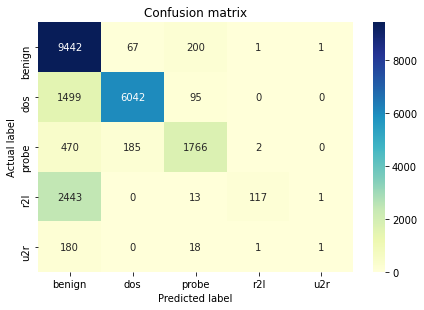

In [ ]:
# create heatmap
sns.heatmap(pd.DataFrame(ran_con), annot=True, cmap="YlGnBu" ,fmt='g',xticklabels= ['benign','dos','probe','r2l','u2r'],yticklabels=['benign','dos','probe','r2l','u2r'])
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Adaptive Boosted Trees**

In [ ]:
# 5. Multi-class AdaBoosted Decision Trees
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")
bdt_discrete.fit(train_x, train_Y)
a_pred = bdt_discrete.predict(test_x)
mat = confusion_matrix(test_Y,a_pred)
print(classification_report(test_Y,a_pred))
print(accuracy_score(test_Y,a_pred))

              precision    recall  f1-score   support

      benign       0.67      0.96      0.79      9711
         dos       0.97      0.75      0.84      7636
       probe       0.75      0.72      0.73      2423
         r2l       0.93      0.19      0.31      2574
         u2r       0.33      0.03      0.05       200

    accuracy                           0.76     22544
   macro avg       0.73      0.53      0.55     22544
weighted avg       0.81      0.76      0.74     22544

0.7646823988644429


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,a_pred, labels=["benign", "dos","probe","r2l","u2r"])

array([[[ 8308,  4525],
        [  389,  9322]],

       [[14743,   165],
        [ 1936,  5700]],

       [[19550,   571],
        [  690,  1733]],

       [[19936,    34],
        [ 2095,   479]],

       [[22334,    10],
        [  195,     5]]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mul_c = multilabel_confusion_matrix(test_Y,a_pred, labels=["benign", "dos","probe","r2l","u2r"])
for i in range(len(mul_c)):
    confusion = mul_c[i]
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    print((TP + TN) / float(TP + TN + FP + FN)*100)

78.20262597586941
90.68044712562101
94.40649396735273
90.55624556422995
99.09066713981547


**Confusion Matrix ADA**

Text(0.5, 15.0, 'Predicted label')

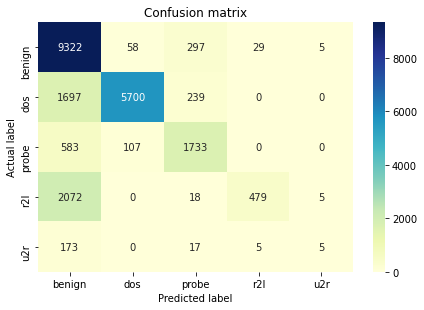

In [ ]:
# create heatmap
sns.heatmap(pd.DataFrame(mat), annot=True, cmap="YlGnBu" ,fmt='g',xticklabels= ['benign','dos','probe','r2l','u2r'],yticklabels=['benign','dos','probe','r2l','u2r'])
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
poacc = [['KNN','RF','LR','SVM','ADA'],[75.51,77.04, 75.30,75.84,76.46]]

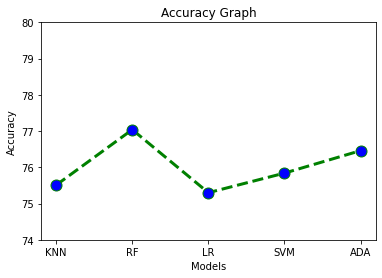

In [ ]:
import matplotlib.pyplot as plt

x = poacc[0]
y = poacc[1]
plt.plot(x,y,color = 'green', linestyle = 'dashed', linewidth = 3, marker = 'o', markerfacecolor = 'blue' , markersize = 11)
plt.ylim(74,80)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.title("Accuracy Graph")
plt.show()